In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Q3 API
from layers import dense 

In [4]:
dataset = np.load('a1_dataset.npz')
dataset.files

['x', 'y']

In [5]:
# 80-10-10 split for train, validate and test images
train_till = int(.8 * dataset['x'].shape[0])
validate_till = int(.9 * dataset['x'].shape[0])

print(train_till, validate_till-train_till, dataset['x'].shape[0]-validate_till)

# training dataset
x_train = dataset['x'][:train_till]/255
y_train = np.eye(96)[dataset['y'][:train_till]]

# validation dataset
x_val = dataset['x'][train_till:validate_till]/255
y_val = np.eye(96)[dataset['y'][train_till:validate_till]]

# testing dataset
x_test = dataset['x'][validate_till:]/255
y_test = np.eye(96)[dataset['y'][validate_till:]]

76800 9600 9600


In [6]:
n_classes = 96
n_features = 2352
batch_size = 50
epochs = 50
learning_rate = 0.1

In [7]:
# input
x_p = tf.placeholder(tf.float32, [None, n_features])
# output
y_p = tf.placeholder(tf.float32, [None, n_classes])

In [8]:
# define architecture
n_l1 = 256
n_l2 = 128

# set up layers
hidden1 = dense(x=x_p, in_length=n_features, neurons=n_l1, activation=tf.nn.relu, layer_name='Layer_1')
hidden2 = dense(x=hidden1, in_length=n_l1, neurons=n_l2, activation=tf.nn.relu, layer_name='Layer_2')
output = dense(x=hidden1, in_length=n_l1, neurons=n_classes, activation=tf.nn.softmax, layer_name='Layer_Output')
y_clipped = tf.clip_by_value(output, 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y_p * tf.log(y_clipped)+ (1 - y_p) * tf.log(1 - y_clipped), axis=1))

optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

In [9]:
prediction_vector = tf.argmax(y_p, 1)
output_vector = tf.argmax(output, 1)

In [10]:
acc, acc_op = tf.metrics.accuracy(prediction_vector, output_vector)

In [11]:
conmat = tf.confusion_matrix(prediction_vector, output_vector)

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    avg_loss = []
    validate_accuracy = []
    total_batches = x_train.shape[0] // batch_size
    
    # Training
    for e in range(epochs):
        avg_loss.append(0.0)
        for b in range(total_batches):
            start = b*batch_size
            end = (b+1)*batch_size
            batch = sess.run([optimiser, cross_entropy], 
                     feed_dict={x_p: x_train[start:end], y_p: y_train[start:end]})
            avg_loss[e] += batch[1] / total_batches
        # validation
        accuracy = sess.run(acc_op,
                 feed_dict={x_p: x_val, y_p: y_val})
        validate_accuracy.append(accuracy)
        print("Epoch:","{:2d}".format(e+1), "train_loss =", "{:.4f}".format(avg_loss[e]), "validate_accuracy =", "{:.4f}".format(validate_accuracy[e]))
        
    # Testing
    test_accuracy, confusion_mat = sess.run([acc_op, conmat],
                    feed_dict={x_p:x_test, y_p:y_test})
    
    print('Testing Accuracy:', test_accuracy)
    print('Confusion Matrix:', confusion_mat)
    tf.io.write_graph(sess.graph_def, 'graphs/', 'line-v3.pbtxt')

Epoch:  1 train_loss = 32.8415 validate_accuracy = 0.0497
Epoch:  2 train_loss = 30.6241 validate_accuracy = 0.0685
Epoch:  3 train_loss = 28.1706 validate_accuracy = 0.0830
Epoch:  4 train_loss = 25.8823 validate_accuracy = 0.0996
Epoch:  5 train_loss = 23.5630 validate_accuracy = 0.1153
Epoch:  6 train_loss = 20.9577 validate_accuracy = 0.1289
Epoch:  7 train_loss = 17.9383 validate_accuracy = 0.1418
Epoch:  8 train_loss = 14.9069 validate_accuracy = 0.1544
Epoch:  9 train_loss = 12.5750 validate_accuracy = 0.1682
Epoch: 10 train_loss = 10.4634 validate_accuracy = 0.1838
Epoch: 11 train_loss = 8.4767 validate_accuracy = 0.2010
Epoch: 12 train_loss = 6.8023 validate_accuracy = 0.2190
Epoch: 13 train_loss = 5.4827 validate_accuracy = 0.2375
Epoch: 14 train_loss = 4.5168 validate_accuracy = 0.2563
Epoch: 15 train_loss = 3.7650 validate_accuracy = 0.2752
Epoch: 16 train_loss = 3.1800 validate_accuracy = 0.2939
Epoch: 17 train_loss = 2.7230 validate_accuracy = 0.3123
Epoch: 18 train_loss 

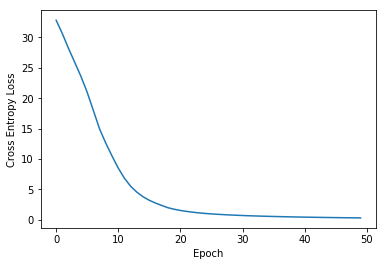

In [13]:
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.plot(avg_loss[None:])
plt.show()

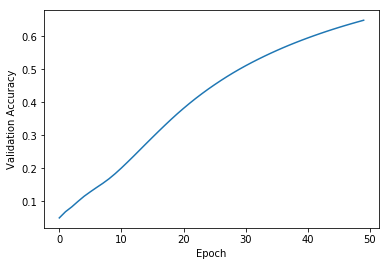

In [14]:
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.plot(validate_accuracy)
plt.show()

In [15]:
True_positives = np.diag(confusion_mat)
False_positives = np.sum(confusion_mat, axis=1) - True_positives
False_negatives = np.sum(confusion_mat, axis=0) - True_positives
Precision = True_positives / (True_positives + False_positives)
print("Precision:", Precision)
Recall = True_positives / (True_positives + False_negatives)
print("\nRecall:", Recall)
F_scores = (2*Precision*Recall) / (Recall+Precision)
print("\nF_scores:", F_scores)

Precision: [0.79090909 0.62105263 0.78571429 0.82828283 0.74025974 0.75789474
 0.92929293 0.5952381  0.72972973 0.91836735 0.58       0.6
 0.76699029 0.68867925 0.83333333 0.68674699 0.68807339 0.72631579
 0.87058824 0.68224299 0.80172414 0.9        0.55555556 0.73033708
 0.86842105 0.73863636 0.90909091 0.84615385 0.94623656 0.91964286
 0.89108911 0.90217391 0.88333333 0.92792793 0.92929293 0.76
 0.83018868 0.82954545 0.95798319 0.85714286 0.93939394 0.90654206
 0.925      0.81904762 0.90291262 0.95       0.92173913 0.84375
 0.96296296 0.98979592 0.99029126 1.         1.         1.
 1.         1.         0.98245614 0.96330275 0.93693694 0.94845361
 0.95555556 0.97916667 1.         1.         0.98958333 1.
 1.         0.98989899 0.97115385 0.99029126 0.98989899 0.93693694
 0.98       1.         1.         1.         0.99029126 1.
 1.         1.         0.96385542 0.97       0.9        1.
 0.98076923 1.         0.99       1.         1.         1.
 1.         1.         0.98913043 1.    

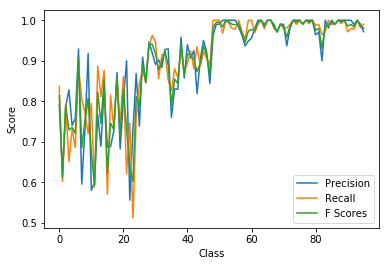

In [16]:
plt.plot(Precision, label='Precision')
plt.plot(Recall, label='Recall')
plt.plot(F_scores, label='F Scores')
plt.ylabel('Score')
plt.xlabel('Class')
plt.legend()
plt.show()

In [17]:
np.savez_compressed('linev3-conmat.npz', cmat=confusion_mat)